In [1]:
! nvidia-smi

Wed Sep 27 20:45:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0  On |                  Off |
| 31%   46C    P8              27W / 450W |   9643MiB / 24564MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# %load_ext autoreload
# %autoreload 2

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import sys
sys.path.append('../../gap/')
from GAP_UNET_ResBlock import UN
from BinomDataset import BinomDataset
from inference import sample_image

# Data
The data will be published shortly.
Links will be provided here.
Importantly, pixel values should contain photon counts and images should not be significantly affected by other types of noise.

# Training

### Loading the data
_________________

We load the data. We can use the full dataset for training, since this is self-supervised and we do not require ground truth.

In [3]:
DIRPATH = "../../../Data/sted GAP test/"
filePaths = [os.path.join(DIRPATH, f) for f in os.listdir(DIRPATH) if f.endswith('.tif')]
fileNames = [os.path.splitext(os.path.basename(f))[0] for f in filePaths]

dataList = []
channelList = []

# load and frint the information of the data
print(f"{'ID':<4}{'NAME':<24}{'SHAPE':<4}")
for idx, name in enumerate(fileNames):
    data = imread(filePaths[idx])
    if len(data.shape) == 3: data = data[:, None, ...]
    data = data.swapaxes(0,1)
    dataList.append(data)
    channelList.append(data.shape[0])
    print(f"{idx:<3}{name[28:]:<25}{data.shape}")

ID  NAME                    SHAPE
0   405Pwr20                (2, 504, 512, 512)
1   405Pwr50                (2, 504, 512, 512)
2   BlankA                  (2, 504, 512, 512)
3   BlankB                  (2, 504, 512, 512)
4   LineAccu1               (3, 517, 512, 512)
5   LineAccu16              (3, 517, 512, 512)
6   LineAccu4               (3, 517, 512, 512)
7   Series049               (3, 11, 512, 512)
8   STEDAccu16 LocationB    (1, 504, 512, 512)
9   STEDAccu16              (1, 504, 512, 512)
10  STEDBlankAccu16         (1, 504, 512, 512)


(504, 512, 512)


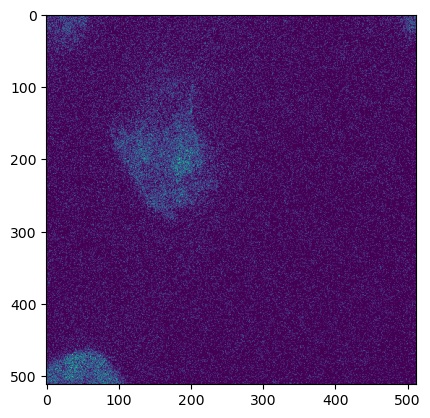

In [4]:
data = dataList[0][0]

plt.imshow(data[100])
print(data.shape)

In [5]:
def psnrToString(inp):
    if inp < 0:
        return 'm'+str(-inp)
    else:
        return str(inp)

# we set the pseudo PSNR range used for splitting the images into input and target
minpsnr = -40
maxpsnr = -5

name = psnrToString(minpsnr)+"to"+psnrToString(maxpsnr)+"-256x256"
CHECKPOINT_PATH = './models/'


In [7]:
from lightning.pytorch.loggers import TensorBoardLogger

maxepochs = 20  # train longer for better results

# Create pytorch dataset
dataset = BinomDataset(
    data[: round(data.shape[0] * 0.9)], 256, minpsnr, maxpsnr, virtSize=500 * 32
)
val_dataset = BinomDataset(data[round(data.shape[0] * 0.9) :], 256, minpsnr, maxpsnr)

# Create pytorch dataloader for training and validation sets
train_loader = dt.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=12,
)
val_loader = dt.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=12,
)

img = next(iter(val_loader))

print(img.shape)

logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = pl.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=0.5,
    devices=[0],
    max_epochs=maxepochs,
    logger=logger,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor("epoch"),
        EarlyStopping("val_loss", patience=2000),
    ],
)
torch.set_float32_matmul_precision('high')
model = UN(channels=1, levels=10, depth=6, start_filts=28, up_mode="transpose").to(
    device
)

torch.Size([32, 2, 256, 256])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | conv_final | Conv2d     | 29    
1 | down_convs | ModuleList | 24.1 M
2 | up_convs   | ModuleList | 9.4 M 
------------------------------------------
33.4 M    Trainable params
0         Non-trainable params
33.4 M    Total params
133.774   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Denoising

In [ ]:
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [ ]:
dataTest = imread('./data/testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT =imread('./data/testDataGT.tif')[:1]
dataTest.shape

(1, 512, 512)

332 0 44.3373404001294 272.0 17.0


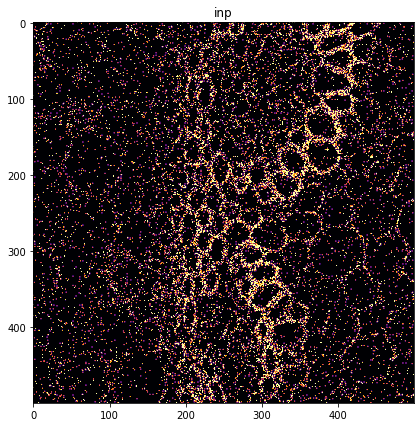

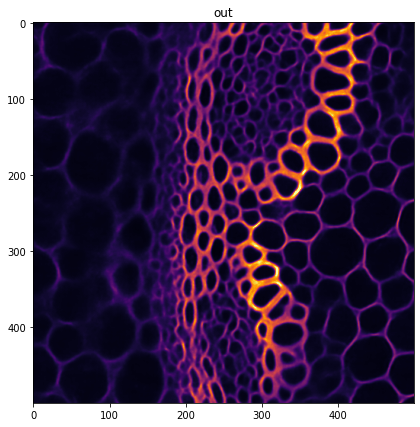

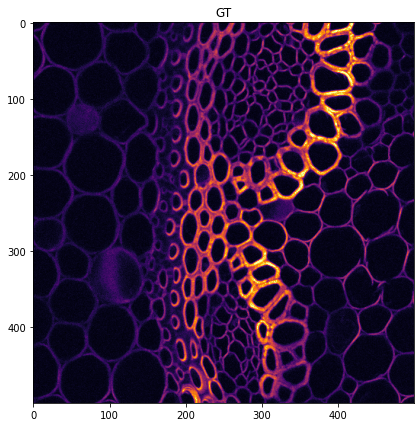

In [ ]:
outputs = []
for inp, gt in zip(dataTest, dataTestGT):  
    inpT = torch.from_numpy(inp.astype(np.float32)).to(device)
    # We have to apply softmax over pixels
    out = torch.exp(model(inpT[None,None,...]).detach().cpu())
    out = inp.sum() * out / out.sum()
    outputs.append(out.numpy()[0,0])
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))
    
    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    vmax = np.percentile(gt,99.9)
    
    plt.figure(figsize=(7,7))
    plt.imshow(inp[:500,:500],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('inp')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(out[0,0][:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('out')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(gt[:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('GT')
    plt.show()


In [ ]:
outputs = np.array(outputs)
imsave('data/output.tif',outputs, imagej = True)

# Sampling images

(1, 1, 256, 256)


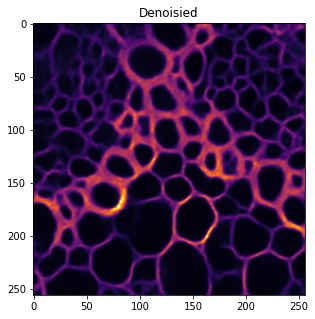

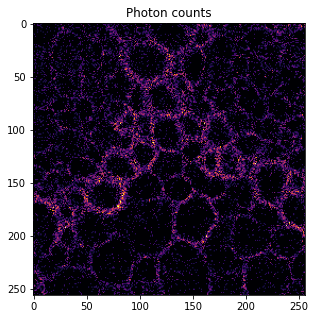

_______________________________________ 154
time (s): 0.8993678092956543 time per image (s) 0.8993678092956543


In [ ]:
import matplotlib.image as mpimg
import time
import numpy as np

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 256
pixels_y = 256

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x).to(device)


for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(inp_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = -5)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)

            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(denoised[j],99.99))
            plt.title('Denoisied')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print ('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])
   

## Looking at the intermediate outputs

0


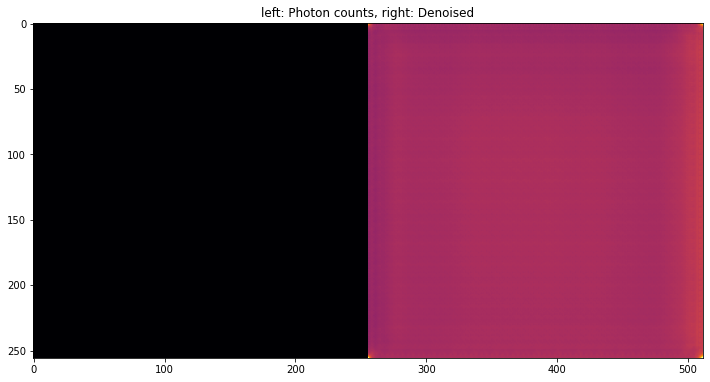

1


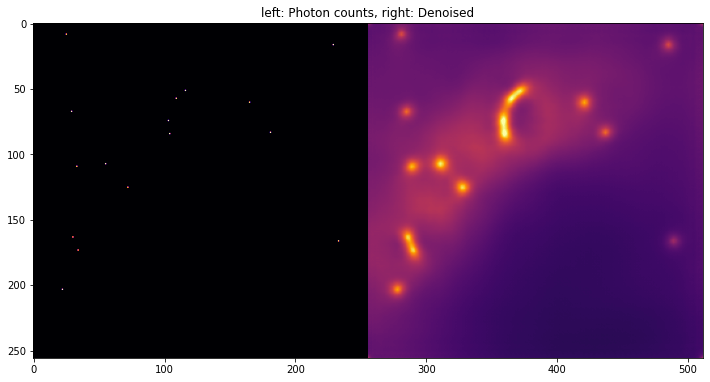

2


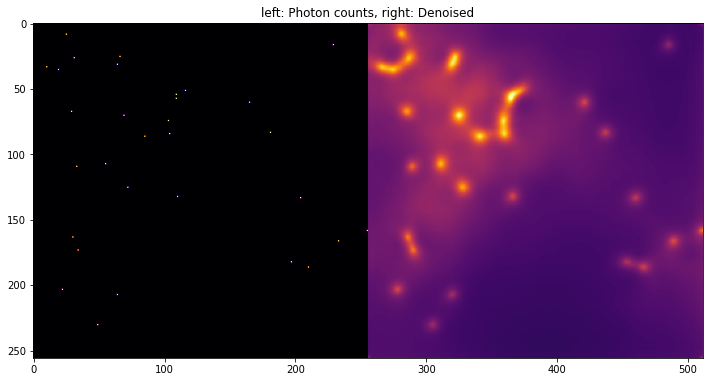

3


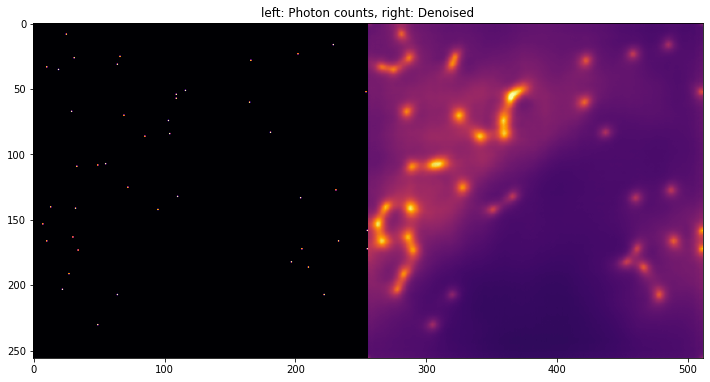

4


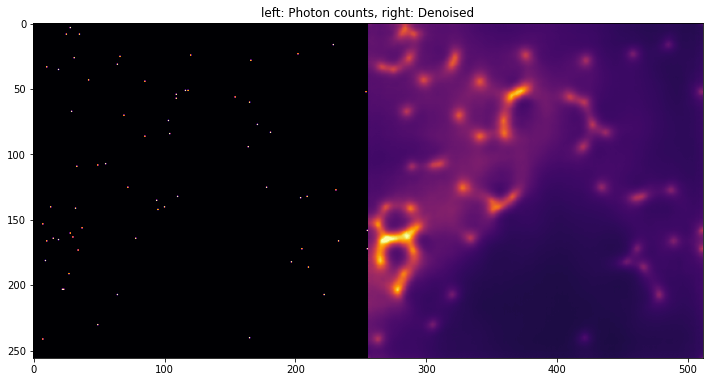

5


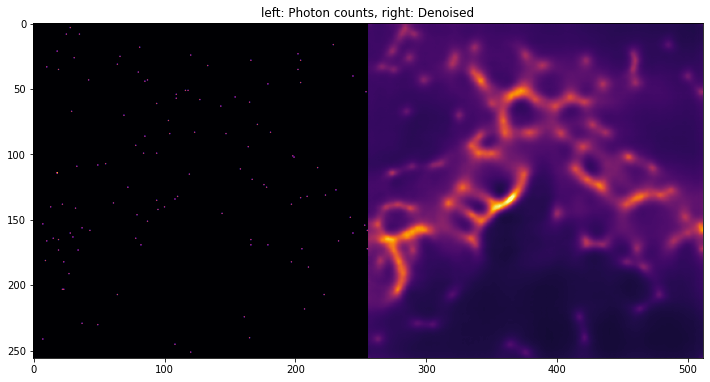

6


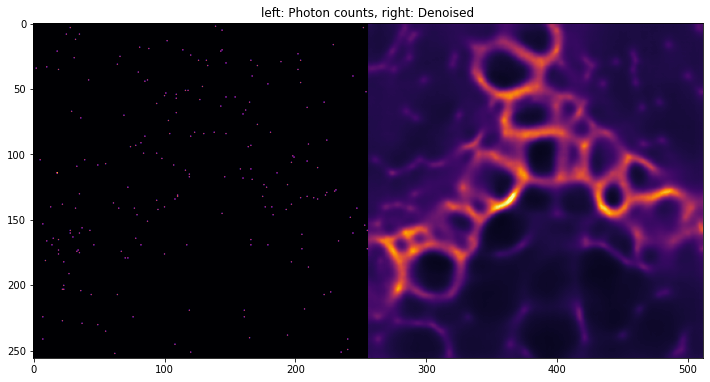

7


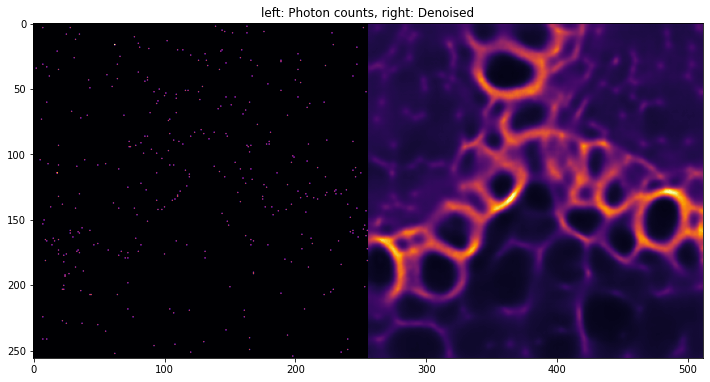

8


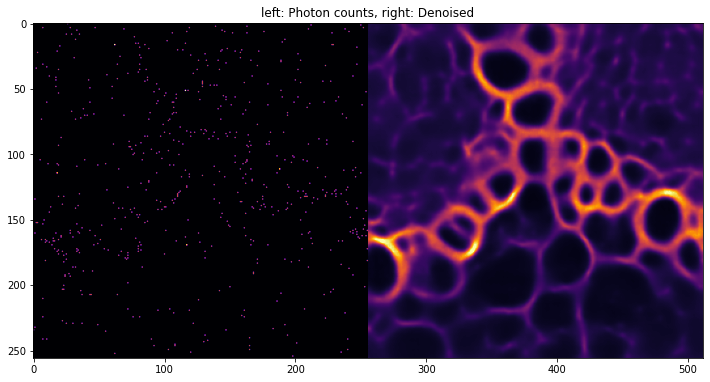

9


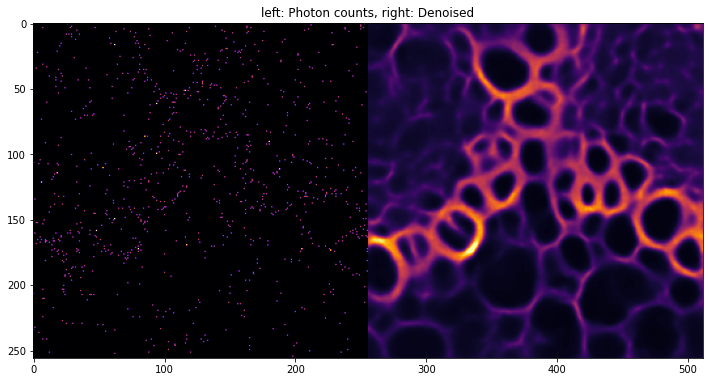

10


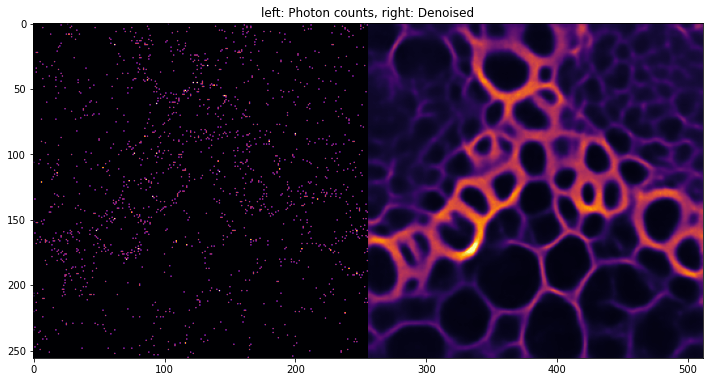

11


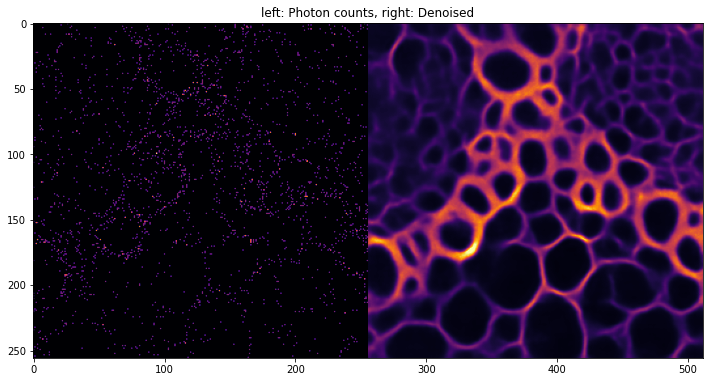

12


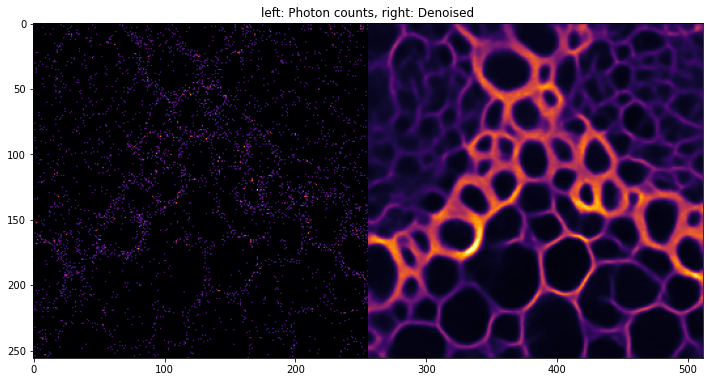

13


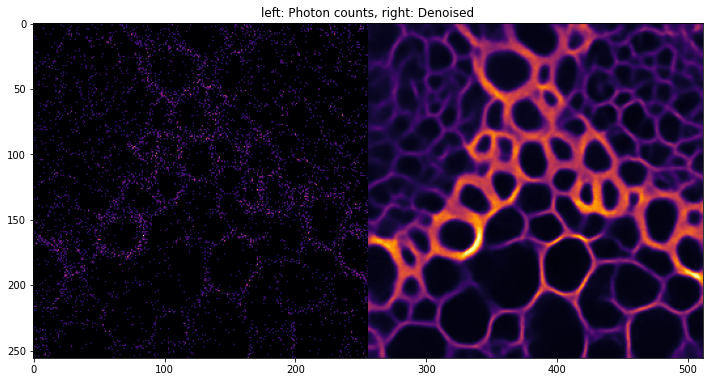

14


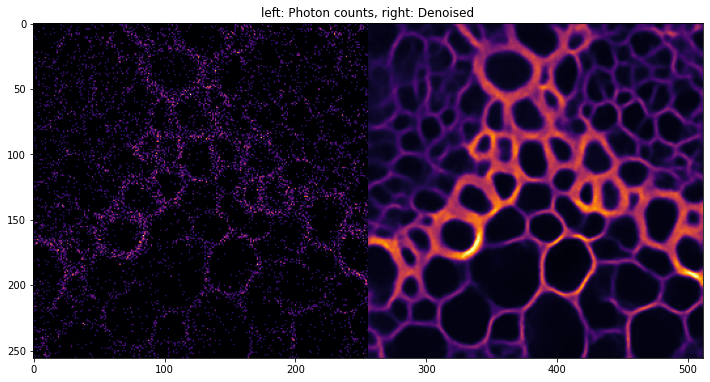

15


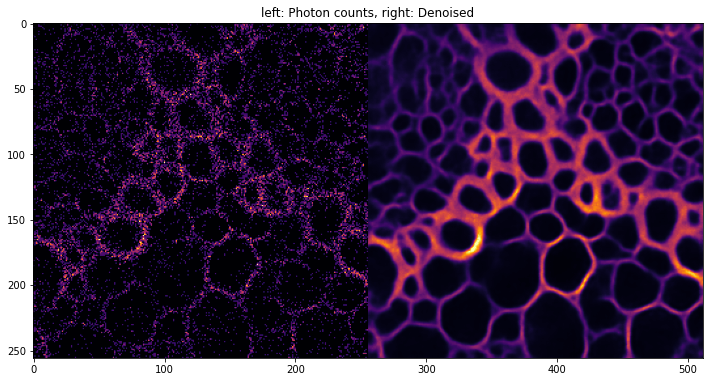

In [ ]:
stack[0].shape
for i in range(len(stack)):
    im = stack[i]
    print(i)
    plt.figure(figsize = (12,12))
    plt.imshow(im,cmap ='inferno', vmax = 0.9)
    plt.title('left: Photon counts, right: Denoised')
    plt.show()